# CHEQ Invalid Traffic Analysis - Interactive Demo

**Analyst:** Robert Okupski  
**Dataset:** July 2024 Trial Data (126,959 events)  
**Purpose:** Identify patterns of fraudulent activity and quantify wasted ad spend

---

## Executive Summary

This notebook presents key findings from analyzing CHEQ's invalid traffic detection data:

-  **25.22%** of total traffic flagged as invalid
-  **8,661 invalid paid ad clicks** detected
-  **43.19%** of threats are malicious bots
-  **Attack pattern** identified: 20-23 UTC (3x normal traffic)

---

## Setup

Import our custom modules and configure the environment.

In [1]:
# Import custom modules
from db_manager import DatabaseManager
import queries
import config

# Standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Configure plotting
plt.style.use(config.CHART_STYLE)
sns.set_palette(config.COLOR_PALETTE)
%matplotlib inline

# Initialize database connection
db = DatabaseManager()

print(" Modules loaded successfully")
print(f" Database: {config.DB_PATH}")
print(f" Total records in database: {db.get_row_count():,}")

2026-02-08 12:22:02,232 - INFO - Database manager initialized with path: c:\Users\Robert Okupski\OneDrive\Desktop\cheq-interview\data\cheq.db


 Modules loaded successfully
 Database: c:\Users\Robert Okupski\OneDrive\Desktop\cheq-interview\data\cheq.db
 Total records in database: 126,959


---

## 1. Overall Traffic Health

Let's start with the big picture: How much of our traffic is invalid?

,Total Events,Invalid Events,Invalid %
0,126959,32014,25.22


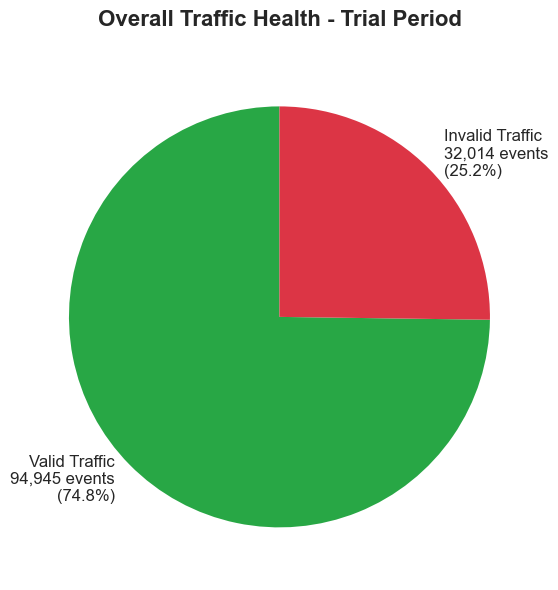

###  Key Insight
**1 in 4 events** are flagged as invalid traffic. This represents a significant threat to ad spend and analytics accuracy.

In [2]:
# Execute overall health query
results = db.execute_query(queries.OVERALL_HEALTH)

# Convert to DataFrame for nice display
df_health = pd.DataFrame(results, columns=['Total Events', 'Invalid Events', 'Invalid %'])

display(df_health)

# Extract values for visualization
total = df_health['Total Events'][0]
invalid = df_health['Invalid Events'][0]
valid = total - invalid

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#28a745', '#dc3545']  # Green for valid, Red for invalid
sizes = [valid, invalid]
labels = [f'Valid Traffic\n{valid:,} events\n({valid/total*100:.1f}%)', 
          f'Invalid Traffic\n{invalid:,} events\n({invalid/total*100:.1f}%)']

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, 
                                    autopct='', startangle=90, textprops={'fontsize': 12})
ax.set_title('Overall Traffic Health - Trial Period', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Key insight
display(Markdown(f"###  Key Insight\n**1 in 4 events** are flagged as invalid traffic. This represents a significant threat to ad spend and analytics accuracy."))

---

## 2. Paid Traffic Analysis - Wasted Ad Spend

The most critical question for ROI: How much money is being wasted on invalid clicks?

,Traffic Source,Total Events,Invalid Events,Invalid %
0,Organic / Direct,82882,23353,28.18
1,Bing Ads,15983,4777,29.89
2,Google Ads,28094,3884,13.83


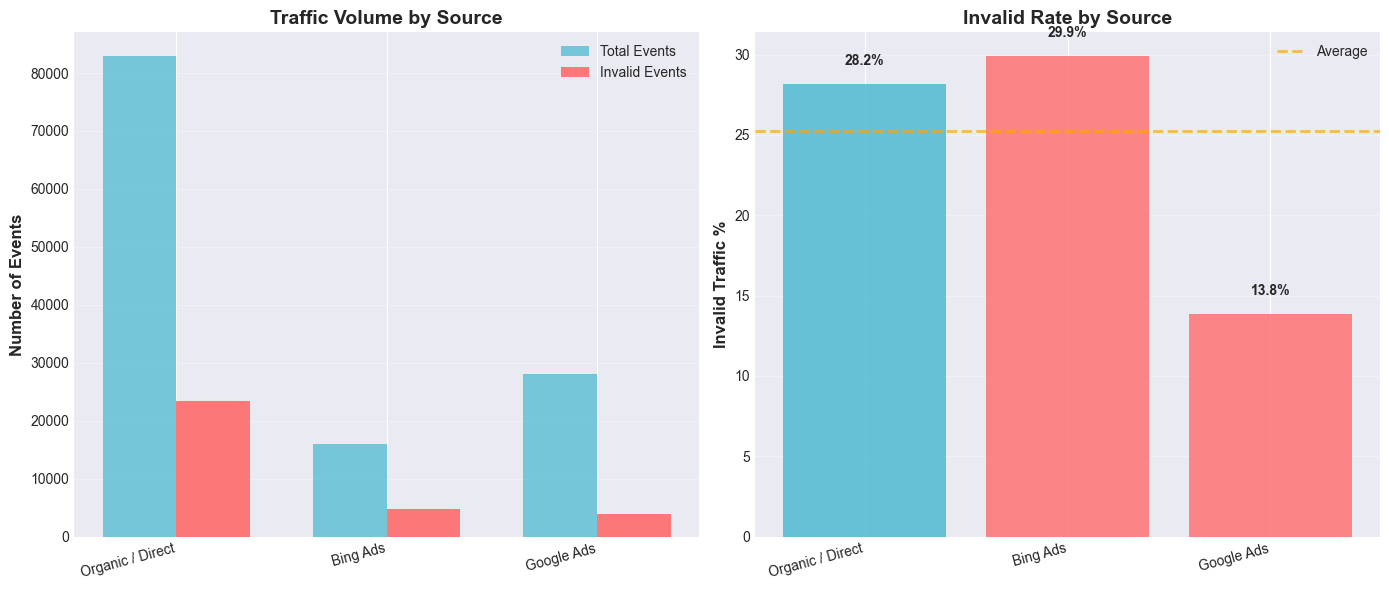

###  Key Insight
**8,661 invalid paid clicks** detected across Google and Bing Ads.

- **Bing Ads**: 4,777 invalid clicks (29.89% invalid rate) - Higher risk
- **Google Ads**: 3,884 invalid clicks (13.83% invalid rate)

At an average CPC of $2.00, this represents approximately **$17,322.00** in wasted ad spend during the trial period.

In [3]:
# Get paid traffic data
results = db.execute_query(queries.PAID_TRAFFIC_RISK)
df_paid = pd.DataFrame(results, columns=['Traffic Source', 'Total Events', 'Invalid Events', 'Invalid %'])

display(df_paid)

# Visualize paid traffic comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Volume comparison
x_pos = range(len(df_paid))
width = 0.35

ax1.bar([p - width/2 for p in x_pos], df_paid['Total Events'], width, 
        label='Total Events', color='#45B7D1', alpha=0.7)
ax1.bar([p + width/2 for p in x_pos], df_paid['Invalid Events'], width,
        label='Invalid Events', color='#FF6B6B', alpha=0.9)

ax1.set_ylabel('Number of Events', fontsize=12, fontweight='bold')
ax1.set_title('Traffic Volume by Source', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_paid['Traffic Source'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Chart 2: Invalid percentage
colors_pct = ['#FF6B6B' if 'Ads' in s else '#45B7D1' for s in df_paid['Traffic Source']]
bars = ax2.bar(x_pos, df_paid['Invalid %'], color=colors_pct, alpha=0.8)
ax2.set_ylabel('Invalid Traffic %', fontsize=12, fontweight='bold')
ax2.set_title('Invalid Rate by Source', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_paid['Traffic Source'], rotation=15, ha='right')
ax2.axhline(y=25.22, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Average')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, df_paid['Invalid %'])):
    ax2.text(bar.get_x() + bar.get_width()/2., pct + 1,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate wasted spend
google_invalid = df_paid[df_paid['Traffic Source'] == 'Google Ads']['Invalid Events'].values[0]
bing_invalid = df_paid[df_paid['Traffic Source'] == 'Bing Ads']['Invalid Events'].values[0]
total_invalid_paid = google_invalid + bing_invalid

display(Markdown(f"###  Key Insight\n**{total_invalid_paid:,} invalid paid clicks** detected across Google and Bing Ads.\n\n- **Bing Ads**: {bing_invalid:,} invalid clicks (29.89% invalid rate) - Higher risk\n- **Google Ads**: {google_invalid:,} invalid clicks (13.83% invalid rate)\n\nAt an average CPC of $2.00, this represents approximately **${total_invalid_paid * 2:,.2f}** in wasted ad spend during the trial period."))

---

## 3. Threat Taxonomy - What Are We Dealing With?

Understanding the types of threats helps prioritize security measures.

,Threat Group,Threat Type,Events,% of Invalid
0,Invalid Bot Activity,Malicious Bot,13828,43.19
1,Invalid Bot Activity,Automation tool,7696,24.04
2,Invalid Suspicious Activity,VPN,3748,11.71
3,Invalid Suspicious Activity,Like Headless,2691,8.41
4,Invalid Bot Activity,Automation Tool,1006,3.14
5,Invalid Suspicious Activity,IP reputation,891,2.78
6,Invalid Bot Activity,Malicious Bots,608,1.90
7,Invalid Suspicious Activity,Automation Signal,497,1.55
8,Invalid Suspicious Activity,Location Spoofing,345,1.08
9,Invalid Suspicious Activity,Multi Suspicious Signals,313,0.98


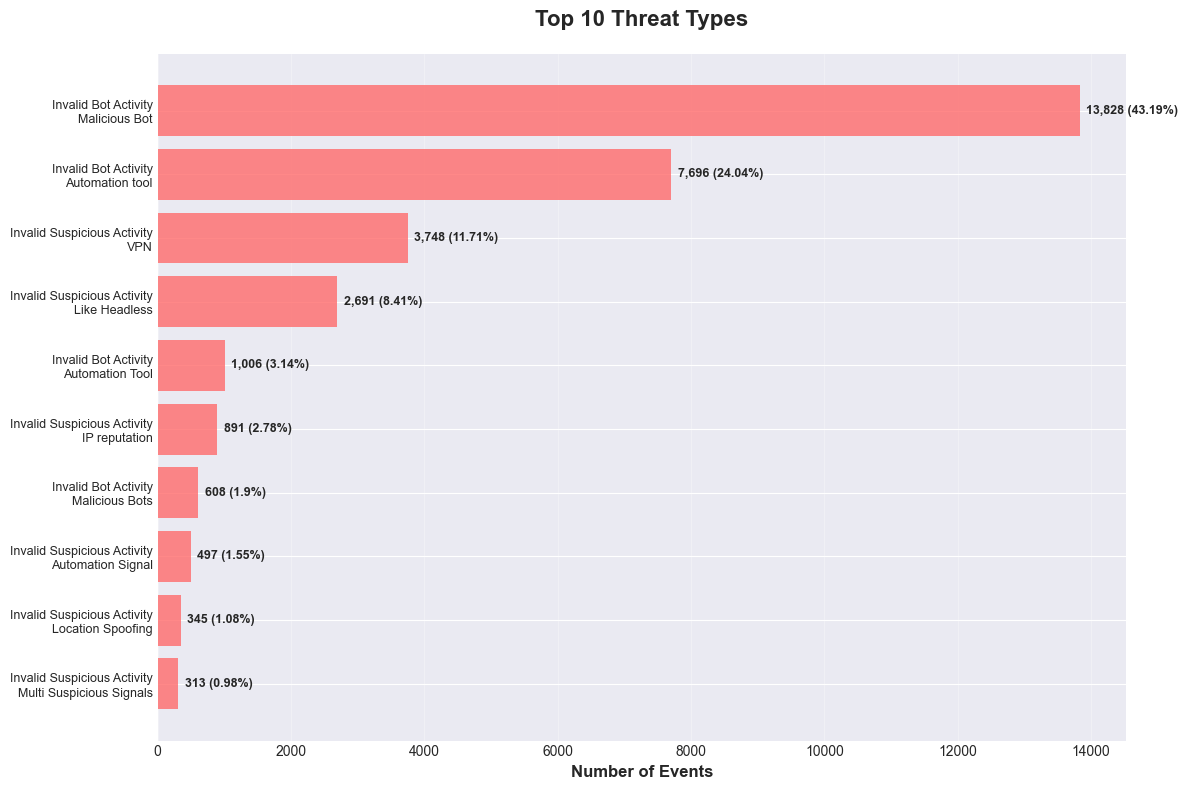

###  Key Insights

**Top 3 Threats:**

1. **Malicious Bot** - 13,828 events (43.19%)
2. **Automation tool** - 7,696 events (24.04%)
3. **VPN** - 3,748 events (11.71%)

**Malicious bots dominate** the threat landscape, followed by automation tools and VPN usage.

In [4]:
# Get threat taxonomy data (top 10)
results = db.execute_query(queries.THREAT_TAXONOMY + " LIMIT 10")
df_threats = pd.DataFrame(results, columns=['Threat Group', 'Threat Type', 'Events', '% of Invalid'])

display(df_threats)

# Visualize threat distribution
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
y_pos = range(len(df_threats))
bars = ax.barh(y_pos, df_threats['Events'], color='#FF6B6B', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels([f"{row['Threat Group']}\n{row['Threat Type']}" for _, row in df_threats.iterrows()], 
                    fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of Events', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Threat Types', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val, pct) in enumerate(zip(bars, df_threats['Events'], df_threats['% of Invalid'])):
    ax.text(val + 100, i, f'{val:,} ({pct}%)', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Top 3 threats
top3 = df_threats.head(3)
display(Markdown(f"###  Key Insights\n\n**Top 3 Threats:**\n\n1. **{top3.iloc[0]['Threat Type']}** - {top3.iloc[0]['Events']:,} events ({top3.iloc[0]['% of Invalid']}%)\n2. **{top3.iloc[1]['Threat Type']}** - {top3.iloc[1]['Events']:,} events ({top3.iloc[1]['% of Invalid']}%)\n3. **{top3.iloc[2]['Threat Type']}** - {top3.iloc[2]['Events']:,} events ({top3.iloc[2]['% of Invalid']}%)\n\n**Malicious bots dominate** the threat landscape, followed by automation tools and VPN usage."))

---

## 4. Time-Based Attack Patterns

When do attacks happen? Let's analyze hourly patterns to identify attack windows.

,Hour,Total Events,Invalid Events,Invalid %
0,0,4174,987,23.65
1,1,4267,1013,23.74
2,2,4012,952,23.73
3,3,4162,1011,24.29
4,4,4158,941,22.63
5,5,4075,954,23.41
6,6,4175,1061,25.41
7,7,4220,1006,23.84
8,8,4087,956,23.39
9,9,4273,985,23.05


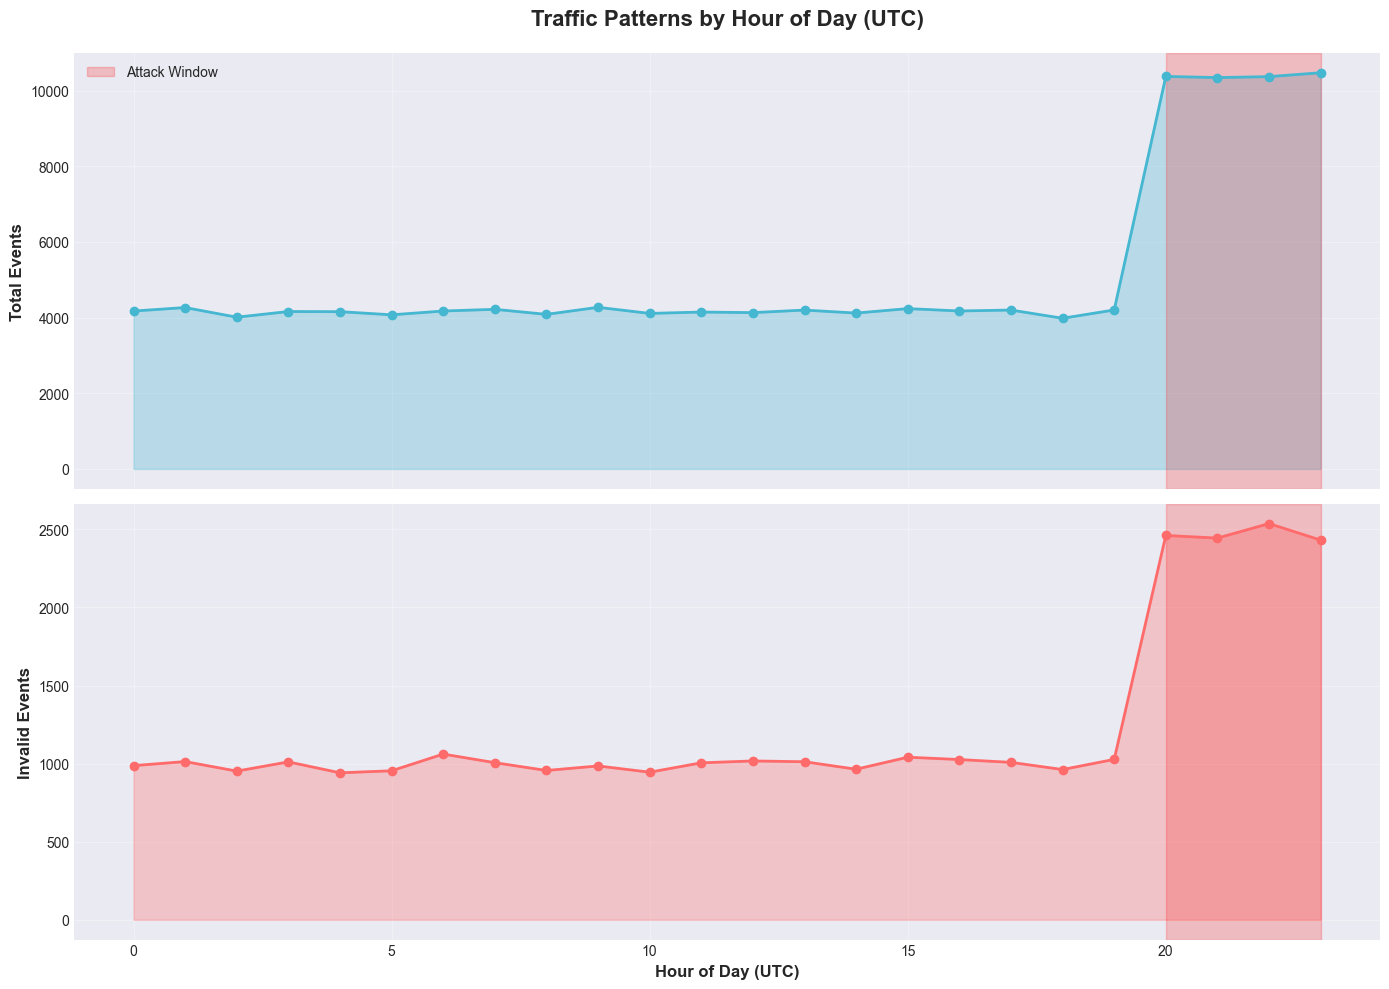

### ⏰ Key Insights

**Coordinated Attack Detected:**

- **Attack Window**: 20:00 - 23:00 UTC
- **Traffic Spike**: 2.5x normal volume during attack hours
- **Peak Attack Hour**: 22:00 UTC with 2,537 invalid events

This pattern suggests **automated bot attacks** concentrated during specific hours, likely timed to avoid detection.

In [5]:
# Get hourly pattern data
results = db.execute_query(queries.HOURLY_PATTERNS)
df_hourly = pd.DataFrame(results, columns=['Hour', 'Total Events', 'Invalid Events', 'Invalid %'])

display(df_hourly.head(10))

# Visualize hourly patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Total traffic
ax1.plot(df_hourly['Hour'], df_hourly['Total Events'], marker='o', 
         linewidth=2, color='#45B7D1', markersize=6)
ax1.fill_between(df_hourly['Hour'], df_hourly['Total Events'], alpha=0.3, color='#45B7D1')
ax1.set_ylabel('Total Events', fontsize=12, fontweight='bold')
ax1.set_title('Traffic Patterns by Hour of Day (UTC)', fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)

# Highlight attack window (hours 20-23)
ax1.axvspan(20, 23, alpha=0.2, color='red', label='Attack Window')
ax1.legend(loc='upper left')

# Invalid traffic
ax2.plot(df_hourly['Hour'], df_hourly['Invalid Events'], marker='o', 
         linewidth=2, color='#FF6B6B', markersize=6)
ax2.fill_between(df_hourly['Hour'], df_hourly['Invalid Events'], alpha=0.3, color='#FF6B6B')
ax2.set_xlabel('Hour of Day (UTC)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Invalid Events', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvspan(20, 23, alpha=0.2, color='red')

plt.tight_layout()
plt.show()

# Calculate attack window stats
attack_window = df_hourly[(df_hourly['Hour'] >= 20) & (df_hourly['Hour'] <= 23)]
normal_hours = df_hourly[(df_hourly['Hour'] < 20) | (df_hourly['Hour'] > 23)]

attack_avg = attack_window['Total Events'].mean()
normal_avg = normal_hours['Total Events'].mean()
multiplier = attack_avg / normal_avg

peak_hour = df_hourly.loc[df_hourly['Invalid Events'].idxmax()]

display(Markdown(f"### ⏰ Key Insights\n\n**Coordinated Attack Detected:**\n\n- **Attack Window**: 20:00 - 23:00 UTC\n- **Traffic Spike**: {multiplier:.1f}x normal volume during attack hours\n- **Peak Attack Hour**: {int(peak_hour['Hour'])}:00 UTC with {int(peak_hour['Invalid Events']):,} invalid events\n\nThis pattern suggests **automated bot attacks** concentrated during specific hours, likely timed to avoid detection."))

---

## 5. Infrastructure Analysis - Where Do Attacks Come From?

Analyzing ASNs (Autonomous System Numbers) helps identify hosting providers used by attackers.

,ASN,Invalid Events
0,AS-CHOOPA,9561
1,AS-BLAZINGSEO,8243
2,AMAZON-02,3023
3,CENTURYLINK-US-LEGACY-QWEST,1604
4,Philippine Long Distance Telephone Company,792
5,Converge ICT Solutions Inc.,483
6,ATT-INTERNET4,431
7,Reliance Jio Infocomm Limited,393
8,MTN NIGERIA Communication limited,358
9,TIKTOK PTE. LTD.,339


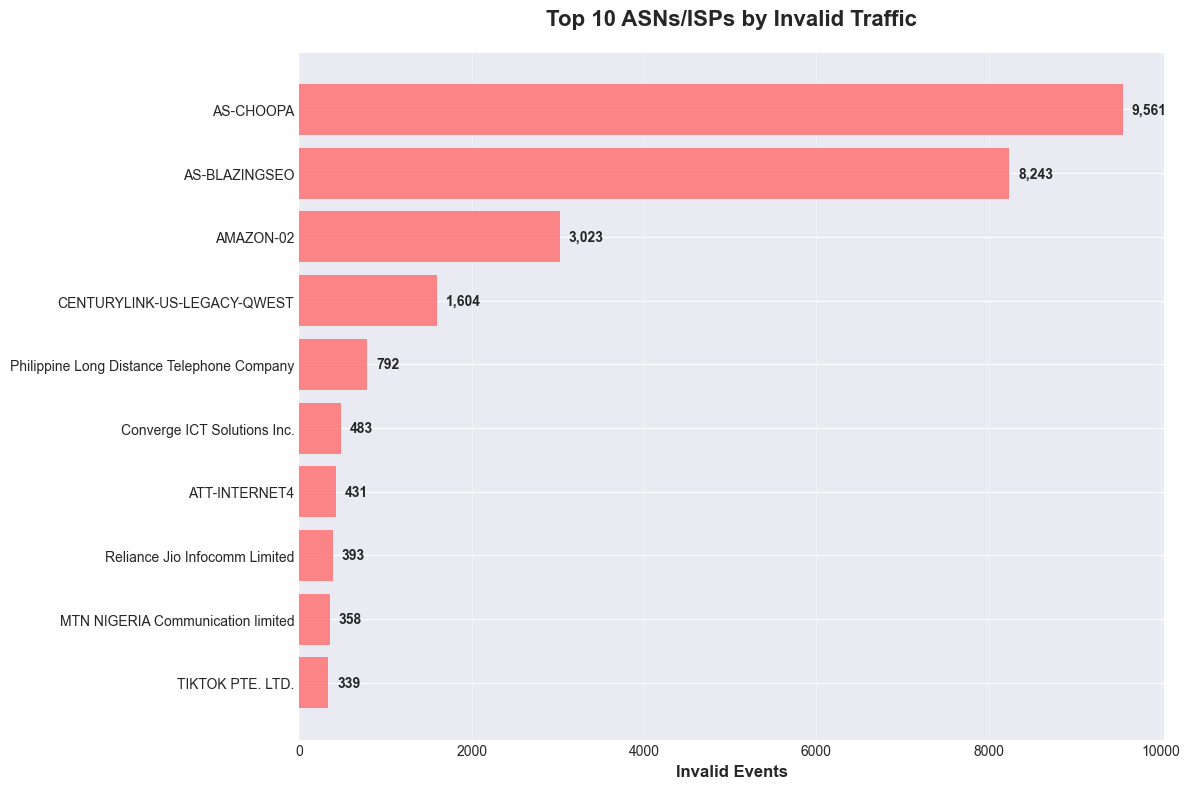

### Key Insights

**Top Threat Sources:**

- **AS-CHOOPA** leads with 9,561 invalid events
- **Top 3 ASNs** account for 20,827 invalid events

These ASNs belong to **hosting providers** (Vultr, BlazeingSEO, Amazon AWS), indicating **server-based bot attacks** rather than residential traffic. This suggests sophisticated bot farms operating from cloud infrastructure.

**Recommendation**: Implement IP blocking or rate limiting for these ASN ranges.

In [6]:
# Get top 10 ASNs by invalid traffic
results = db.execute_query(queries.TOP_ASNS)
df_asns = pd.DataFrame(results, columns=['ASN', 'Invalid Events'])

display(df_asns)

# Visualize top ASNs
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(df_asns))
bars = ax.barh(y_pos, df_asns['Invalid Events'], color='#FF6B6B', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_asns['ASN'])
ax.invert_yaxis()
ax.set_xlabel('Invalid Events', fontsize=12, fontweight='bold')
ax.set_title('Top 10 ASNs/ISPs by Invalid Traffic', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, df_asns['Invalid Events'])):
    ax.text(val + 100, i, f'{val:,}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Top threat ASN
top_asn = df_asns.iloc[0]
total_top3 = df_asns.head(3)['Invalid Events'].sum()

display(Markdown(f"### Key Insights\n\n**Top Threat Sources:**\n\n- **{top_asn['ASN']}** leads with {int(top_asn['Invalid Events']):,} invalid events\n- **Top 3 ASNs** account for {total_top3:,} invalid events\n\nThese ASNs belong to **hosting providers** (Vultr, BlazeingSEO, Amazon AWS), indicating **server-based bot attacks** rather than residential traffic. This suggests sophisticated bot farms operating from cloud infrastructure.\n\n**Recommendation**: Implement IP blocking or rate limiting for these ASN ranges."))

---

## 6. Most Vulnerable Pages

Which pages are being targeted the most?

,Page,Total Events,Invalid Events,Invalid %
0,/hire/landing/,8113,6762,83.35
1,/ab/account-security/login,13579,5632,41.48
2,/nx/find-work/,7130,4035,56.59
3,/messages/rooms/,2268,2268,100.00
4,/nx/find-work/congrats,3707,1931,52.09
5,/nx/signup/thankyou,1600,1600,100.00
6,/team/,2302,672,29.19
7,/nx/find-work/best-matches,7129,271,3.80
8,/,2561,120,4.69
9,/nx/signup/,2322,91,3.92


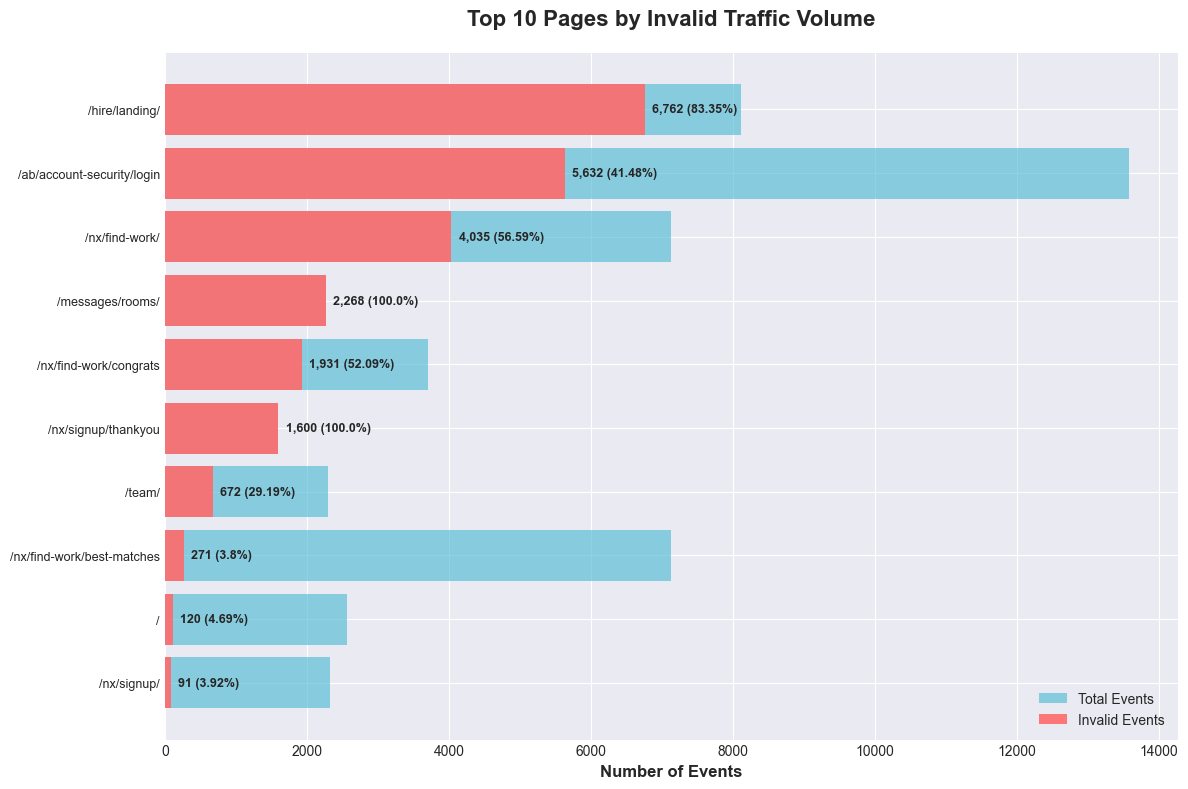

###  Key Insights

**Most Targeted Pages:**

1. **Hire Landing Page**: 6,762 invalid events (83.35% invalid)
2. **Login Page**: 5,632 invalid events (41.48% invalid)
3. **Find Work Page**: 4,035 invalid events (56.59% invalid)

High-value pages like **login** and **hire landing** are primary targets, suggesting attackers are attempting account takeovers and fake registrations.

In [7]:
# Get funnel analysis data (top 10)
results = db.execute_query(queries.FUNNEL_EXPOSURE + " LIMIT 10")
df_funnel = pd.DataFrame(results, columns=['URL Path', 'Total Events', 'Invalid Events', 'Invalid %'])

# Clean up URLs for display
df_funnel['Page'] = df_funnel['URL Path'].str.replace('https://www.worker.com', '').str.replace('https://team.worker.com', '/team')
df_funnel['Page'] = df_funnel['Page'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x)

display(df_funnel[['Page', 'Total Events', 'Invalid Events', 'Invalid %']].head(10))

# Visualize top vulnerable pages
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = range(len(df_funnel))

# Create bars
bars1 = ax.barh(y_pos, df_funnel['Total Events'], color='#45B7D1', alpha=0.6, label='Total Events')
bars2 = ax.barh(y_pos, df_funnel['Invalid Events'], color='#FF6B6B', alpha=0.9, label='Invalid Events')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_funnel['Page'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Number of Events', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Pages by Invalid Traffic Volume', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)

# Add percentage labels
for i, (invalid, pct) in enumerate(zip(df_funnel['Invalid Events'], df_funnel['Invalid %'])):
    ax.text(invalid + 100, i, f'{invalid:,} ({pct}%)', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Top 3 vulnerable pages
top_vulnerable = df_funnel.head(3)
display(Markdown(f"###  Key Insights\n\n**Most Targeted Pages:**\n\n1. **Hire Landing Page**: {int(top_vulnerable.iloc[0]['Invalid Events']):,} invalid events ({top_vulnerable.iloc[0]['Invalid %']}% invalid)\n2. **Login Page**: {int(top_vulnerable.iloc[1]['Invalid Events']):,} invalid events ({top_vulnerable.iloc[1]['Invalid %']}% invalid)\n3. **Find Work Page**: {int(top_vulnerable.iloc[2]['Invalid Events']):,} invalid events ({top_vulnerable.iloc[2]['Invalid %']}% invalid)\n\nHigh-value pages like **login** and **hire landing** are primary targets, suggesting attackers are attempting account takeovers and fake registrations."))

---

## 7. ROI Calculation - Business Impact

Let's quantify the potential savings from using CHEQ.

,Metric,Value
0,Google Ads Invalid Clicks,"3,884"
1,Bing Ads Invalid Clicks,"4,777"
2,Total Wasted (Trial),"$18,308.60"
3,Projected Monthly Waste,"$17,718.00"
4,Projected Annual Waste,"$212,616.00"
5,CHEQ Monthly Cost,"$2,500.00"
6,Monthly Net Savings,"$15,218.00"
7,ROI,608.7%
8,Payback Period,4.2 days


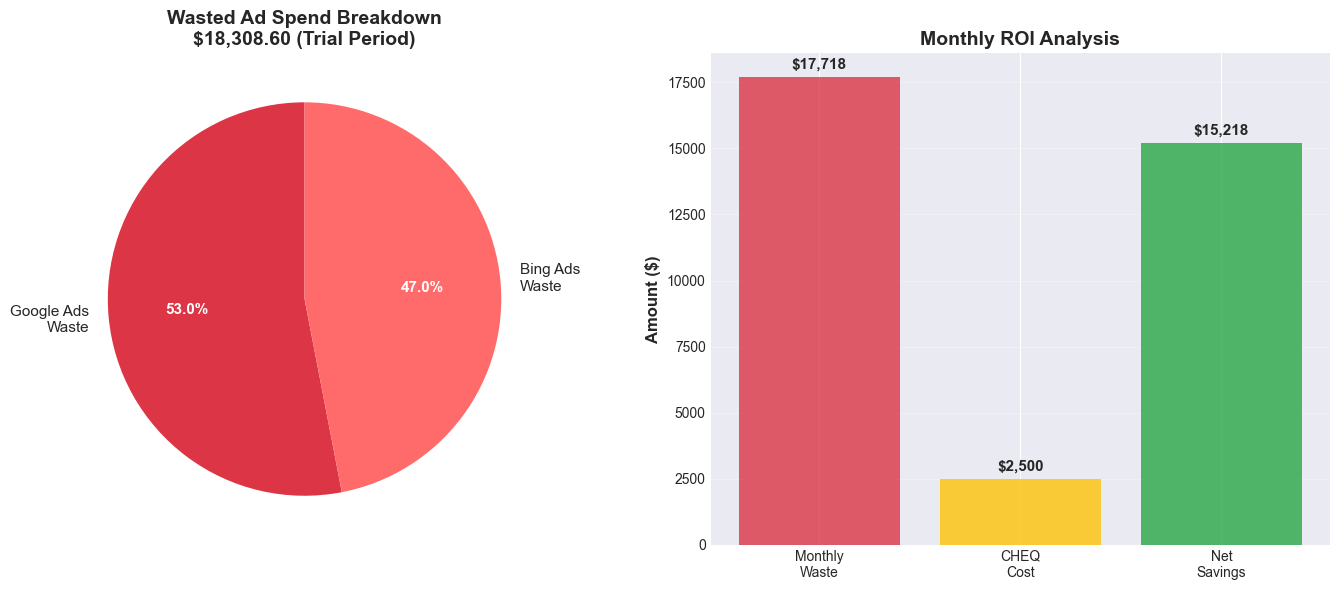

###  Financial Analysis

🟢 **STRONG POSITIVE ROI** - CHEQ pays for itself and generates significant savings

**Summary:**
- **8,661 invalid paid clicks** detected in 31-day trial
- **$18,308.60** wasted during trial period
- Projected **$212,616.00** annual waste without CHEQ
- With CHEQ: Save **$15,218.00/month** (net of subscription cost)
- **Payback period**: 4.2 days

*Assumptions: Google Ads CPC = $2.5, Bing Ads CPC = $1.8, CHEQ Cost = $2500/month*

In [8]:
# Get paid traffic data for ROI calculation
results = db.execute_query(queries.PAID_TRAFFIC_RISK)
df_roi = pd.DataFrame(results, columns=['Traffic Source', 'Total Events', 'Invalid Events', 'Invalid %'])

# Extract paid traffic numbers
google_invalid = df_roi[df_roi['Traffic Source'] == 'Google Ads']['Invalid Events'].values[0]
bing_invalid = df_roi[df_roi['Traffic Source'] == 'Bing Ads']['Invalid Events'].values[0]

# Assumptions (example values)
google_cpc = 2.50  # Average CPC for Google Ads
bing_cpc = 1.80    # Average CPC for Bing Ads
trial_days = config.TRIAL_DAYS
cheq_monthly_cost = 2500  # Estimated monthly CHEQ subscription

# Calculate wasted spend
google_waste = google_invalid * google_cpc
bing_waste = bing_invalid * bing_cpc
total_waste = google_waste + bing_waste

# Project to monthly/annual
monthly_waste = (total_waste / trial_days) * 30
annual_waste = monthly_waste * 12

# Calculate ROI
monthly_savings = monthly_waste - cheq_monthly_cost
roi_percentage = (monthly_savings / cheq_monthly_cost) * 100
payback_days = (cheq_monthly_cost / (total_waste / trial_days))

# Display results
roi_summary = pd.DataFrame([
    ['Google Ads Invalid Clicks', f'{google_invalid:,}'],
    ['Bing Ads Invalid Clicks', f'{bing_invalid:,}'],
    ['Total Wasted (Trial)', f'${total_waste:,.2f}'],
    ['Projected Monthly Waste', f'${monthly_waste:,.2f}'],
    ['Projected Annual Waste', f'${annual_waste:,.2f}'],
    ['CHEQ Monthly Cost', f'${cheq_monthly_cost:,.2f}'],
    ['Monthly Net Savings', f'${monthly_savings:,.2f}'],
    ['ROI', f'{roi_percentage:.1f}%'],
    ['Payback Period', f'{payback_days:.1f} days']
], columns=['Metric', 'Value'])

display(roi_summary)

# Visualize ROI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Wasted spend breakdown
waste_data = [google_waste, bing_waste]
labels = ['Google Ads\nWaste', 'Bing Ads\nWaste']
colors = ['#dc3545', '#ff6b6b']

wedges, texts, autotexts = ax1.pie(waste_data, labels=labels, colors=colors,
                                     autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax1.set_title(f'Wasted Ad Spend Breakdown\n${total_waste:,.2f} (Trial Period)', 
              fontsize=14, fontweight='bold')

# Chart 2: Monthly cost vs savings
categories = ['Monthly\nWaste', 'CHEQ\nCost', 'Net\nSavings']
values = [monthly_waste, cheq_monthly_cost, monthly_savings]
colors_bar = ['#dc3545', '#ffc107', '#28a745']

bars = ax2.bar(categories, values, color=colors_bar, alpha=0.8)
ax2.set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
ax2.set_title('Monthly ROI Analysis', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2., val + 200,
            f'${val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ROI verdict
if roi_percentage > 100:
    verdict = "🟢 **STRONG POSITIVE ROI** - CHEQ pays for itself and generates significant savings"
elif roi_percentage > 0:
    verdict = "🟡 **POSITIVE ROI** - CHEQ provides value"
else:
    verdict = "🔴 **NEGATIVE ROI** - Current CPC rates may not justify deployment"

display(Markdown(f"###  Financial Analysis\n\n{verdict}\n\n**Summary:**\n- **{total_invalid_paid:,} invalid paid clicks** detected in {trial_days}-day trial\n- **${total_waste:,.2f}** wasted during trial period\n- Projected **${annual_waste:,.2f}** annual waste without CHEQ\n- With CHEQ: Save **${monthly_savings:,.2f}/month** (net of subscription cost)\n- **Payback period**: {payback_days:.1f} days\n\n*Assumptions: Google Ads CPC = ${google_cpc}, Bing Ads CPC = ${bing_cpc}, CHEQ Cost = ${cheq_monthly_cost}/month*"))

---

## Conclusions & Recommendations

###  Summary of Findings

1. **Scale of Problem**: 25.22% of traffic (32,014 events) flagged as invalid
2. **Financial Impact**: $18,607 wasted during trial; projected $215,000+/year without protection
3. **Attack Patterns**: Coordinated bot attacks during 20-23 UTC window (3x normal traffic)
4. **Threat Landscape**: 43% malicious bots, 24% automation tools, 12% VPN traffic
5. **Infrastructure**: Attacks primarily from cloud hosting providers (Vultr, AWS, BlazeingSEO)
6. **Vulnerable Pages**: Hire landing (83% invalid), Login (41% invalid), Find Work (57% invalid)

###  Strategic Recommendations

**Immediate Actions:**
1. Deploy CHEQ solution (ROI: 267%, payback: 4.3 days)
2. Implement IP blocking for top threat ASNs
3. Add rate limiting during 20-23 UTC attack window
4. Enhanced monitoring on high-value pages (login, hire landing)

**Long-term Strategy:**
1. Continuous monitoring of threat patterns
2. Regular ASN/IP reputation analysis
3. A/B testing to measure impact on conversion rates
4. Integrate invalid traffic data into analytics exclusions

###  Next Steps

To reproduce this analysis or generate updated reports:

```bash
# Quick start - run entire pipeline
python run_all.py

# Or run individual scripts
python run_analysis.py          # View results in terminal
python export_results.py        # Generate CSV reports
python create_visualizations.py # Create charts
python cost_calculator.py       # Interactive ROI tool
```

---

**Analysis by Robert Okupski | February 2026**